# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from enum import Enum
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


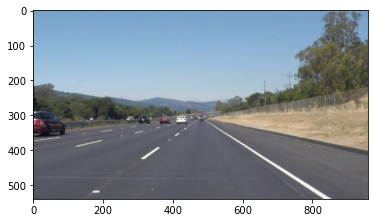

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [1571]:
import ipywidgets as widgets

from IPython.display import display

slider1 = widgets.IntSlider()



def on_slider1_value_change(change):
    print(slider1.value)
    
slider1.observe(on_slider1_value_change, 'value')

display(slider1)


IntSlider(value=0)

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'hard.png', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']


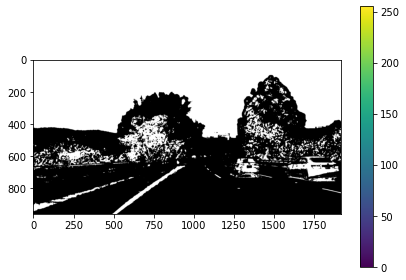

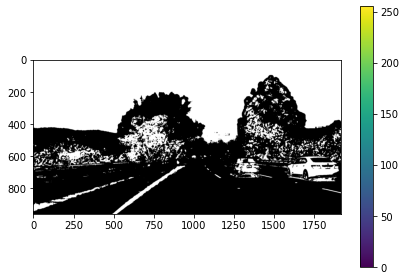

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

IntSlider(value=0, max=255)

IntSlider(value=0, max=255)

IntSlider(value=75, max=255)

IntSlider(value=255, max=255)

IntSlider(value=255, max=255)

IntSlider(value=255, max=255)

In [1622]:
viewport_left_x = 400
viewport_right_x = 550
viewport_y = 320
mid_of_viewport_x = math.floor(((viewport_right_x - viewport_left_x)/2) + viewport_left_x)

class Lanes:
    def __init__(self):
        self.x = 0
        
    def draw_left_lane(target_image, left_lines, image_height):
        last_line_count = 0
        chosen_left_lane = None
        for left_line in left_lines:
            left_lane = FullLeftLanePolygon.create_from_left_line(left_line, Viewport.y(target_image.image_data), image_height)
            line_count = left_lane.contains_lines(left_lines)
            if last_line_count < line_count:
                last_line_count = line_count
                chosen_left_lane = left_lane
                
        if chosen_left_lane == None:
            if len(left_lines) > 0:
                chosen_left_lane = FullLeftLanePolygon.create_from_left_line(left_lines[0], Viewport.y(target_image.image_data), image_height)
        
        
        if chosen_left_lane != None:
            Lanes.last_left_lane = chosen_left_lane
            
        if Lanes.last_left_lane != None:
            PolygonPlotter.draw_to(target_image, Lanes.last_left_lane.polygon.arr, (0, 0, 255)) 
            
    def draw_right_lane(target_image, right_lines, image_height):
        last_line_count = 0
        chosen_right_lane = None

        for right_line in right_lines:
            right_lane = FullRightLanePolygon.create_from_right_line(right_line, Viewport.y(target_image.image_data), image_height)
            line_count = right_lane.contains_lines(right_lines)
            if last_line_count < line_count:
                last_line_count = line_count
                chosen_right_lane = right_lane
                
        if chosen_right_lane == None:
            if len(right_lines) > 0:
                chosen_right_lane = FullRightLanePolygon.create_from_right_line(right_lines[0], Viewport.y(target_image.image_data), image_height)
        
        
        if chosen_right_lane != None:
            Lanes.last_right_lane = chosen_right_lane
            
        if Lanes.last_right_lane != None:
            PolygonPlotter.draw_to(target_image, Lanes.last_right_lane.polygon.arr, (0, 0, 255))      
            

        
    @staticmethod
    def draw_to(target_image, left_lines, right_lines, image_height):
        Lanes.draw_left_lane(target_image, left_lines, image_height)
        Lanes.draw_right_lane(target_image, right_lines, image_height)

        

Lanes.last_left_lane = None
Lanes.last_right_lane = None
    
    

class LoadAs(Enum):
    Grayscale = 1
    ColorBGR = 2
    ColorRGB = 3
    ColorHSV = 4
    ColorHSL = 5
    
class CvImage:
    def __init__(self):
        self.load_as = None
        self.image_data = np.array([], dtype=np.int32)

    @staticmethod
    def create_black_image(width, height, channel_count = 3):
        image_data = np.zeros((height, width, channel_count), np.uint8)

        return CvImage.from_cv_image_data(image_data, LoadAs.ColorBGR)

    @staticmethod
    def load_from_file(filepath, load_as = LoadAs.ColorBGR):
        instance = CvImage()
        instance.load_as = load_as
        if load_as == LoadAs.Grayscale:
            instance.image_data = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        else:
            instance.image_data = cv2.imread(filepath)
            
        return instance
    
    @staticmethod
    def from_cv_image_data(cv_image_data, load_as = LoadAs.ColorBGR):
        
#         if cv_image_data.shape[0] == 0:
#             return None
        
        instance = CvImage()
        instance.load_as = load_as
        instance.image_data = cv_image_data
        
        return instance
    
    @staticmethod
    def load_from_image_data(cv_image_data, load_as = LoadAs.ColorBGR):
        return CvImage.from_cv_image_data(cv_image_data, load_as)

    def _get_intensity_m(self, brightness_value):
        intensitym = np.ones(self.image_data.shape, dtype="uint8") * brightness_value
        
        return intensitym
    
    def darken(self, darken_value):
        intensitym = self._get_intensity_m(darken_value)
        darkened_image_data = cv2.subtract(self.image_data, intensitym)
        
        return CvImage.load_from_image_data(darkened_image_data, self.load_as)
    
    def brighten(self, darken_value):
        intensitym = self._get_intensity_m(darken_value)
        darkened_image_data = cv2.add(self.image_data, intensitym)
        
        return CvImage.load_from_image_data(darkened_image_data, self.load_as)

    def height(self):
#         if self.image_data.shape[0] == 0:
#             return 0
        height, width = self.image_data.shape[:2]
        
        return height
    
    def width(self):
#         if self.image_data.shape[0] == 0:
#             return 0
        height, width = self.image_data.shape[:2]
        
        return width
        

    def channel_count(self):
#         if self.image_data.shape[0] == 0:
#             return 0
        return self.image_data.shape[2]
    
    def to_grayscale(self):
#         if self.image_data.shape[0] == 0:
#             return None        
        grayscale_image = cv2.cvtColor(self.image_data, cv2.COLOR_BGR2GRAY)
        
        return CvImage.from_cv_image_data(grayscale_image, LoadAs.Grayscale)
    

    def mask_and(self, other_image):
        result = cv2.bitwise_and(self.image_data, other_image.image_data)
        
        return CvImage.load_from_image_data(result)
    
    def mask_or(self, other_image):
        result = cv2.bitwise_or(self.image_data, other_image.image_data)
        
        return CvImage.load_from_image_data(result)

    def mask_xor(self, other_image):
        result = cv2.bitwise_xor(self.image_data, other_image.image_data)
        
        return CvImage.load_from_image_data(result)

    def mask_not(self):
        result = cv2.bitwise_not(self.image_data)
        
        return CvImage.load_from_image_data(result)
    
    def to_HSV(self):
        hsv = cv2.cvtColor(self.image_data, cv2.COLOR_RGB2HSV)
        
        return CvImage.load_from_image_data(hsv, LoadAs.ColorHSV)

    def to_HSL(self):
        hsv = cv2.cvtColor(self.image_data, cv2.COLOR_RGB2HLS)
        
        return CvImage.load_from_image_data(hsv, LoadAs.ColorHSL)
    
    def to_RGB(self):
        if self.load_as == LoadAs.Grayscale:
            rgb_image = cv2.cvtColor(self.image_data, cv2.COLOR_GRAY2RGB)
            
            return CvImage.load_from_image_data(rgb_image, LoadAs.ColorRGB)
        else:
            rgb_image = cv2.cvtColor(self.image_data, cv2.COLOR_BGR2RGB)

            return CvImage.load_from_image_data(rgb_image, LoadAs.ColorRGB)
    
    def gaussian_blur(self, kernel_size = 5):
        blurred = cv2.GaussianBlur(self.image_data, (kernel_size, kernel_size), 0)
        
        return CvImage.load_from_image_data(blurred, self.load_as);
    
    def threshold(self, black_threshold, other_color, ttype):
        ret, result = cv2.threshold(self.image_data, black_threshold, other_color, ttype)
        
        return CvImage.load_from_image_data(result, self.load_as)
    
    def threshold_binary(self, black_threshold, other_color):
        return self.threshold(black_threshold, other_color, cv2.THRESH_BINARY)
        
    def threshold_binary_inverse(self, black_threshold, other_color):
        return self.threshold(black_threshold, other_color, cv2.THRESH_BINARY_INV)

    def threshold_truncate(self, black_threshold, other_color):
        return self.threshold(black_threshold, other_color, cv2.THRESH_TRUNC)
    
    def threshold_to_zero(self, black_threshold, other_color):
        return self.threshold(black_threshold, other_color, cv2.THRESH_TOZERO)
    
    def canny(self, low_threshold = 50, high_threshold = 150, aperture_size = 3):
        cannied = cv2.Canny(self.image_data, low_threshold, high_threshold, aperture_size)
        
        return CvImage.load_from_image_data(cannied)
    
    def houghlines(self, original_image = None, threshold = 200):
        rho = 1 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 40     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 20 #minimum number of pixels making up a line
        max_line_gap = 5    # maximum gap in pixels between connectable line segments
        
        lines = cv2.HoughLinesP(self.image_data, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)

        black_image = CvImage.create_black_image(self.to_RGB().width(), self.to_RGB().height(), self.to_RGB().channel_count())
        right_line_color = [255, 0, 0]
        left_line_color = [0, 0, 255]
        thickness = 2
        
        left_lines = []
        right_lines = []
        
#         PolygonPlotter.draw_to(black_image, Viewport.left_area_polygon(self.image_data).arr)
#         PolygonPlotter.draw_to(black_image, Viewport.right_area_polygon(self.image_data).arr)

        if not (lines is None) :
            for line_arr in lines:
                line = Line.create_from_array(line_arr)
                if line.abs_dx() > 0 and line.abs_dy() > 0:                
                    if line.is_inside(Viewport.right_area_polygon(self.image_data)):
                        if line.slope() > 0.5 and line.slope() < 0.7:
                            right_lines.append(line)
                    elif line.is_inside(Viewport.left_area_polygon(self.image_data)):
                        if line.slope() < -0.6 and line.slope() > -0.8:
                            left_lines.append(line)
                        


        if original_image is None:
            Lanes.draw_to(black_image, left_lines, right_lines, self.height())
            return black_image
        else:            
            Lanes.draw_to(original_image, left_lines, right_lines, self.height())
            return original_image
        
                
    
    def filter_inrange(self, lower_value, upper_value):
        filtered = cv2.inRange(self.image_data, lower_value, upper_value)
        
        return CvImage.load_from_image_data(filtered)

class Lane:
    def slope(self, x1, y1, x2, y2):
        divider = (x2-x1)
        if divider == 0: return 0
        m = (y2-y1)/divider
        return m    
    def contains_lines(self, whole_lines):
        line_count = 0
        for line in whole_lines:
            if line.is_inside(self.polygon):
                line_count += 1
                
        return line_count
    
    
class FullLeftLanePolygon(Lane):
    
    @staticmethod
    def create_from_left_line(left_line, viewport_y, image_height):
        additional_area = 5
        left_lane = FullLeftLanePolygon()
        left_lane.top = left_lane.normalize_left_lane_right_most_point([left_line.x2, left_line.y2], viewport_y, [left_line.x1, left_line.y1])
        left_lane.bottom = left_lane.normalize_left_lane_left_most_point([left_line.x1, left_line.y1], image_height, [left_line.x2, left_line.y2])
        
        left_lane.polygon = Polygon.create_from_array(np.array([(left_lane.top[0] - additional_area + 2, left_lane.top[1]), (left_lane.bottom[0] - additional_area, left_lane.bottom[1]), \
                                        (left_lane.bottom[0] + additional_area, left_lane.bottom[1]), (left_lane.top[0] + additional_area - 2, left_lane.top[1])]))
    
    
        return left_lane
    
    
    def normalize_left_lane_right_most_point(self, left_lane_right_most_point, viewport_y, left_lane_left_most_point):
        if left_lane_right_most_point[1] != viewport_y:
            line_slope = self.slope(left_lane_left_most_point[0], left_lane_left_most_point[1], left_lane_right_most_point[0], left_lane_right_most_point[1])
            right_most_x = (line_slope * left_lane_right_most_point[0] + (viewport_y - left_lane_right_most_point[1])) / line_slope
            left_lane_right_most_point = [math.floor(right_most_x), viewport_y]

        return left_lane_right_most_point

    def normalize_left_lane_left_most_point(self, left_lane_left_most_point, image_bottom, left_lane_right_most_point):
        if left_lane_left_most_point[1] != image_bottom:
            line_slope = self.slope(left_lane_left_most_point[0], left_lane_left_most_point[1], left_lane_right_most_point[0], left_lane_right_most_point[1])
            left_most_x = (line_slope * left_lane_left_most_point[0] + (image_bottom - left_lane_left_most_point[1])) / line_slope
            left_lane_left_most_point = [math.floor(left_most_x), image_bottom]

        return left_lane_left_most_point
    
class FullRightLanePolygon(Lane):
    
    @staticmethod
    def create_from_right_line(right_line, viewport_y, image_height):
        additional_area = 5
        right_lane = FullRightLanePolygon()
        right_lane.top = right_lane.normalize_right_lane_left_most_point([right_line.x2, right_line.y2], viewport_y, [right_line.x1, right_line.y1])
        right_lane.bottom = right_lane.normalize_right_lane_right_most_point([right_line.x1, right_line.y1], image_height, [right_line.x2, right_line.y2])
        
        right_lane.polygon = Polygon.create_from_array(np.array([(right_lane.top[0] - additional_area + 2, right_lane.top[1]), (right_lane.bottom[0] - additional_area, right_lane.bottom[1]), \
                                        (right_lane.bottom[0] + additional_area, right_lane.bottom[1]), (right_lane.top[0] + additional_area - 2, right_lane.top[1])]))
    
    
        return right_lane
    
    
    def normalize_right_lane_right_most_point(self, right_lane_right_most_point, image_bottom, right_lane_left_most_point):
        if right_lane_right_most_point[1] != image_bottom:
            line_slope = self.slope(right_lane_left_most_point[0], right_lane_left_most_point[1], right_lane_right_most_point[0], right_lane_right_most_point[1])
            right_most_x = (line_slope * right_lane_right_most_point[0] + (image_bottom - right_lane_right_most_point[1])) / line_slope
            right_lane_right_most_point = [math.floor(right_most_x), image_bottom]

        return right_lane_right_most_point

    def normalize_right_lane_left_most_point(self, right_lane_left_most_point, viewport_y, right_lane_right_most_point):
        if right_lane_left_most_point[1] != viewport_y:
            line_slope = self.slope(right_lane_left_most_point[0], right_lane_left_most_point[1], right_lane_right_most_point[0], right_lane_right_most_point[1])
            left_most_x = (line_slope * right_lane_left_most_point[0] + (viewport_y - right_lane_left_most_point[1])) / line_slope
            right_lane_left_most_point = [math.floor(left_most_x), viewport_y]

        return right_lane_left_most_point
    
    
    
    
class Viewport:    
    
    @staticmethod
    def y(image):
        height, width = image.shape[:2]
        viewport_y = math.floor(height / 2) + 50

        if height != 720:
            viewport_y += 50
        else:
            viewport_y += 100
        
        return viewport_y
    
    @staticmethod
    def whole_area_polygon(image):
        height, width = image.shape[:2]
        mid_of_viewport_x = math.floor(width / 2)
        viewport_y = math.floor(height / 2) #+ 50 + 90
        
        if height != 720:
            viewport_y += 50
        else:
            viewport_y += 100
        
        viewport_right_x = mid_of_viewport_x + 30
        viewport_left_x = mid_of_viewport_x - 30
        return Polygon.create_from_array(np.array([(viewport_left_x, viewport_y), (0, height), (width, height), (viewport_right_x, viewport_y)]))         
        
    
    @staticmethod
    def right_area_polygon(image):
        height, width = image.shape[:2]
        mid_of_viewport_x = math.floor(width / 2)
        viewport_y = math.floor(height / 2) #+ 50 + 90

        if height != 720:
            viewport_y += 50
        else:
            viewport_y += 100
        
        viewport_right_x = mid_of_viewport_x + 30
        return Polygon.create_from_array(np.array([(mid_of_viewport_x + 1, viewport_y), (mid_of_viewport_x + 1, height), (width, height), (viewport_right_x, viewport_y)]))         
    
    @staticmethod
    def left_area_polygon(image):
        height, width = image.shape[:2]
        mid_of_viewport_x = math.floor(width / 2)
        viewport_y = math.floor(height / 2) #+ 50 + 90
        
        if height != 720:
            viewport_y += 50
        else:
            viewport_y += 100
        
        viewport_left_x = mid_of_viewport_x - 30
        return Polygon.create_from_array(np.array([(viewport_left_x, viewport_y), (0,height), (mid_of_viewport_x, height), (mid_of_viewport_x, viewport_y)]))         
    
    @staticmethod
    def get_mask_image(target_image):
        viewport_image = CvImage.create_black_image(target_image.width(), target_image.height(), target_image.channel_count())

        vertices = Viewport.whole_area_polygon(target_image.image_data)
        PolygonPlotter.draw_to(viewport_image, vertices.arr)
        
        return viewport_image
        
    
class Polygon:
    @staticmethod
    def create_from_array(arr):
        poly = Polygon(arr)
        
        return poly
        
    def __init__(self, arr):
        self.arr = arr
        
    def is_point_inside(self, point_tuple):
        result = cv2.pointPolygonTest(self.arr, point_tuple, False)         
        
        return (result >= 0)
        
    
class Line:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        
    @staticmethod
    def create_from_array(arr):
        x1, y1, x2, y2 = arr[0]
        new_line = Line(x1, y1, x2, y2)
        
        return new_line
    
    
    def abs_dx(self):
        return abs(self.dx())
        
    def abs_dy(self):
        return abs(self.dy())

    def dx(self):
        return self.x1 - self.x2
        
    def dy(self):
        return self.y1 - self.y2
    
    def slope(self):
        return self.dy() / self.dx()
    
    def is_inside(self, polygon):
        return (polygon.is_point_inside((self.x1, self.y1)) and polygon.is_point_inside((self.x2, self.y2)))
        
    
class LinePlotter:
    @staticmethod
    def draw_to(target_image, point1, point2, thickness = 4, bgr_color = (100, 255, 0)):
        cv2.line(target_image.image_data, point1, point2, bgr_color, thickness)
        
class CirclePlotter:
    @staticmethod
    def draw_to(target_image, center_point, radius, bgr_color = (100, 255, 0), solid_color = -1):
        cv2.circle(target_image.image_data, center_point, radius, bgr_color, solid_color)
        
class RectanglePlotter:
    @staticmethod
    def draw_to(target_image, left_point, right_point, bgr_color, solid_color = -2):
        cv2.rectangle(target_image.image_data, left_point, right_point, bgr_color, solid_color)
    
class PolygonPlotter:
    @staticmethod
    def draw_to(target_image, vertices, color_value = (255, 255, 255)):
        adapted_vertices = np.array([vertices], dtype=np.int32)
        cv2.fillPoly(target_image.image_data, adapted_vertices, color_value)
    
    
class ImageViewer:
    @staticmethod
    def display_image(cv_image):        
        result = plt.imshow(cv_image.to_RGB().image_data)
        
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        
        return result

import os

print(os.listdir("test_images/"))


cvimage = CvImage.load_from_file('test_images/hard.png')

# yellow_mask = cvimage.to_HSL().filter_inrange(np.array([50, 158, 79]),np.array([105, 254, 255]))
yellow_mask = cvimage.to_HSL().filter_inrange(np.array([0, 0, 75]),np.array([255, 255, 255]))
white_mask = cvimage.to_HSL().filter_inrange(np.array([0, 211, 0]),np.array([255, 255, 255]))
mask1 = cvimage.to_HSL().filter_inrange(np.array([0, 229, 103]),np.array([255, 255, 255]))
mask2 = cvimage.to_HSL().filter_inrange((0, 0, 100),(255,255,255))



dark_image = mask1.mask_or(mask2).to_RGB().mask_and(Viewport.get_mask_image(cvimage))

# dark_image = dark_image.threshold_binary(20, 100)

masked_image = CvImage.load_from_image_data(np.copy(cvimage.image_data))
masked_image.image_data[mask1.image_data != 0] = [0,0,0]

# ImageViewer.display_image(cvimage.to_HSL())
# ImageViewer.display_image(masked_image)
ImageViewer.display_image(mask1.mask_or(yellow_mask))
ImageViewer.display_image(white_mask.mask_or(yellow_mask))
# ImageViewer.display_image(dark_image.canny().houghlines(cvimage))
# ImageViewer.display_image(cvimage)


slider_low_H = widgets.IntSlider(max =255)
slider_low_S = widgets.IntSlider(max =255)
slider_low_V = widgets.IntSlider(max =255)

slider_high_H = widgets.IntSlider(max =255)
slider_high_S = widgets.IntSlider(max =255)
slider_high_V = widgets.IntSlider(max =255)

slider_low_H.value = 0
slider_low_S.value = 0
slider_low_V.value = 75
slider_high_H.value = slider_high_S.value = slider_high_V.value = 255

mask1 = cvimage.to_HSL().filter_inrange(np.array([slider_low_H.value, slider_low_S.value, slider_low_V.value]),np.array([slider_high_H.value, slider_high_S.value, slider_high_V.value]))
imgbox = widgets.Image(format='jpg', height=300, width=400)
imgbox.value = cv2.imencode('.jpg', mask1.image_data)[1].tobytes()
display(imgbox)    



def redisplay_mask():
    mask1 = cvimage.to_HSL().filter_inrange(np.array([slider_low_H.value, slider_low_S.value, slider_low_V.value]),np.array([slider_high_H.value, slider_high_S.value, slider_high_V.value]))
    imgbox.value = cv2.imencode('.jpg', mask1.image_data)[1].tobytes()
    


def on_slider_value_change(change):
    redisplay_mask()
    
slider_low_H.observe(on_slider_value_change, 'value')
slider_low_S.observe(on_slider_value_change, 'value')
slider_low_V.observe(on_slider_value_change, 'value')

slider_high_H.observe(on_slider_value_change, 'value')
slider_high_S.observe(on_slider_value_change, 'value')
slider_high_V.observe(on_slider_value_change, 'value')

display(slider_low_H, slider_low_S, slider_low_V, slider_high_H, slider_high_S, slider_high_V)



## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [107]:



rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments



def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
#     return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def increase_brightness(img, value=30):
    image = cv2.add(img, np.array([value]))
    return image
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Image should have already been converted to HSL color space
def isolate_yellow_hsl(img):
    low_threshold = np.array([15, 38, 115], dtype=np.uint8)
    high_threshold = np.array([35, 204, 255], dtype=np.uint8)  
    yellow_mask = cv2.inRange(img, low_threshold, high_threshold)
    return yellow_mask
                            
# Image should have already been converted to HSL color space
def isolate_white_hsl(img):
    low_threshold = np.array([0, 200, 0], dtype=np.uint8)
    high_threshold = np.array([180, 255, 255], dtype=np.uint8)  
    white_mask = cv2.inRange(img, low_threshold, high_threshold)
    return white_mask

def combine_yw_isolated(img, hsl_img):
    hsl_yellow = isolate_yellow_hsl(hsl_img)
    hsl_white = isolate_white_hsl(hsl_img)
    hsl_mask = cv2.bitwise_or(hsl_yellow, hsl_white)
    return cv2.bitwise_and(img, img, mask=hsl_mask)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)

#     cv2.fillPoly(mask, vertices, 100)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#     return mask


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def get_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    return lines
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def get_image(file_path):
#     image = mpimg.imread(file_path)
    image = cv2.imread(file_path)
    
    return image

def bgr_to(img, colr):
    if colr == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colr == "hsl":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif colr == 'gray':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def get_masked_image(original_image, gauss_kernel_size=5, canny_low=50, canny_high=150):
    image = original_image

#     gray = grayscale(image)
#     darkened = increase_brightness(image, -50.0)
    
    isolated = combine_yw_isolated(original_image, bgr_to(original_image, "hsl"))
    
    blur_gray = gaussian_blur(isolated, gauss_kernel_size)
    

    edges = canny(isolated, canny_low, canny_high)

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(viewport_left_x, viewport_y), (viewport_right_x, viewport_y), (imshape[1],imshape[0])]], dtype=np.int32)
    masked = region_of_interest(edges, vertices)
    
    return masked


def normalize_left_lane_right_most_point(left_lane_right_most_point, viewport_y, left_lane_left_most_point):
    if left_lane_right_most_point[1] != viewport_y:
        line_slope = slope(left_lane_left_most_point[0], left_lane_left_most_point[1], left_lane_right_most_point[0], left_lane_right_most_point[1])
        right_most_x = (line_slope * left_lane_right_most_point[0] + (viewport_y - left_lane_right_most_point[1])) / line_slope
        left_lane_right_most_point = [math.floor(right_most_x), viewport_y]
    
    return left_lane_right_most_point

def normalize_left_lane_left_most_point(left_lane_left_most_point, image_bottom, left_lane_right_most_point):
    if left_lane_left_most_point[1] != image_bottom:
        line_slope = slope(left_lane_left_most_point[0], left_lane_left_most_point[1], left_lane_right_most_point[0], left_lane_right_most_point[1])
        left_most_x = (line_slope * left_lane_left_most_point[0] + (image_bottom - left_lane_left_most_point[1])) / line_slope
        left_lane_left_most_point = [math.floor(left_most_x), image_bottom]
    
    return left_lane_left_most_point

def normalize_right_lane_right_most_point(right_lane_right_most_point, image_bottom, right_lane_left_most_point):
    if right_lane_right_most_point[1] != image_bottom:
        line_slope = slope(right_lane_left_most_point[0], right_lane_left_most_point[1], right_lane_right_most_point[0], right_lane_right_most_point[1])
        right_most_x = (line_slope * right_lane_right_most_point[0] + (image_bottom - right_lane_right_most_point[1])) / line_slope
        right_lane_right_most_point = [math.floor(right_most_x), image_bottom]
    
    return right_lane_right_most_point

def normalize_right_lane_left_most_point(right_lane_left_most_point, viewport_y, right_lane_right_most_point):
    if right_lane_left_most_point[1] != viewport_y:
        line_slope = slope(right_lane_left_most_point[0], right_lane_left_most_point[1], right_lane_right_most_point[0], right_lane_right_most_point[1])
        left_most_x = (line_slope * right_lane_left_most_point[0] + (viewport_y - right_lane_left_most_point[1])) / line_slope
        right_lane_left_most_point = [math.floor(left_most_x), viewport_y]
    
    return right_lane_left_most_point


def draw_lane_lines(original_image, masked_image):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    
    linesarr = get_hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    
    

    
    left_lane_left_most_point = [100000, 100000]
    left_lane_right_most_point = [-1, -1]
    
    
    right_lane_left_most_point = [100000, 100000]
    right_lane_right_most_point = [-1, -1]
    
    
    for line in linesarr:
        for x1,y1,x2,y2 in line:
            slopeval = slope(x1, y1, x2, y2)
#             print(slopeval, line)
            if slopeval >= 0.05 and (x1 >= mid_of_viewport_x and x2 >= mid_of_viewport_x):
                if right_lane_left_most_point[0] > x1:
                    right_lane_left_most_point = [x1, y1]
                    
                if right_lane_right_most_point[0] < x2:
                    right_lane_right_most_point = [x2, y2]
                    
            elif slopeval < 0.05 and (x1 < mid_of_viewport_x and x2 < mid_of_viewport_x):
                if left_lane_left_most_point[0] > x1 :
                    left_lane_left_most_point = [x1, y1]
                    
                if left_lane_right_most_point[0] < x2:
                    left_lane_right_most_point = [x2, y2]
                    
    line_img = np.zeros((original_image.shape[0], original_image.shape[1], 3), dtype=np.uint8)        

#     print("left_lane:", left_lane_left_most_point, left_lane_right_most_point)
    
#     print("right_lane:", right_lane_left_most_point, right_lane_right_most_point)
    
    
    image_bottom = original_image.shape[1]
        
    left_lane_right_most_point = normalize_left_lane_right_most_point(left_lane_right_most_point, viewport_y, left_lane_left_most_point)
    left_lane_left_most_point = normalize_left_lane_left_most_point(left_lane_left_most_point, image_bottom, left_lane_right_most_point)    

    right_lane_right_most_point = normalize_right_lane_right_most_point(right_lane_right_most_point, image_bottom, right_lane_left_most_point)
    right_lane_left_most_point = normalize_right_lane_left_most_point(right_lane_left_most_point, viewport_y, right_lane_right_most_point)
    
    line_thickness=6 
    cv2.line(line_img, (left_lane_left_most_point[0], left_lane_left_most_point[1]), (left_lane_right_most_point[0], left_lane_right_most_point[1]), [255, 0, 0], line_thickness)    
    cv2.line(line_img, (right_lane_left_most_point[0], right_lane_left_most_point[1]), (right_lane_right_most_point[0], right_lane_right_most_point[1]), [255, 0, 0], line_thickness)
    
    weighted_lines = weighted_img(line_img, original_image)
                
    return weighted_lines
    

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def slope(x1, y1, x2, y2):
    divider = (x2-x1)
    if divider == 0: return 0
    m = (y2-y1)/divider
    return m

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [1123]:
import os
print(os.listdir("test_images/"))

original_image = get_image('test_images/whiteCarLaneSwitch.jpg')

print('This image is:', type(original_image), 'with dimensions:', original_image.shape)

masked_image = get_masked_image(original_image, 5, 50, 150)

# final_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
final_image = draw_lane_lines(original_image, masked_image)

plt.imshow(final_image) 

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']


NameError: name 'get_image' is not defined

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


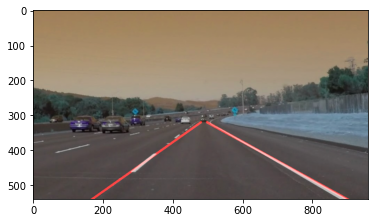

In [109]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
original_image = get_image('test_images/solidWhiteCurve.jpg')

print('This image is:', type(original_image), 'with dimensions:', original_image.shape)

masked_image = get_masked_image(original_image, 5, 50, 150)

final_image = draw_lane_lines(original_image, masked_image)

plt.imshow(final_image) 

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1630]:
def process_image(image):
    cvimage = CvImage.load_from_image_data(image)
    


#     dark_image = cvimage.filter_inrange((80,120, 86), (255,255, 255)).to_RGB().mask_and(Viewport.get_mask_image(cvimage))

#     mask1 = cvimage.filter_inrange((190, 190, 190), (255,255, 255))
#     mask2 = cvimage.filter_inrange((80, 120, 86), (255,255, 255))

    yellow_mask = cvimage.to_HSL().filter_inrange(np.array([0, 0, 75]),np.array([255, 255, 255]))
    white_mask = cvimage.to_HSL().filter_inrange(np.array([0, 211, 0]),np.array([255, 255, 255]))


    dark_image = yellow_mask.mask_or(white_mask).to_RGB().mask_and(Viewport.get_mask_image(cvimage))

    
    return dark_image.canny().houghlines(cvimage).image_data
    

Let's try the one with the solid white lane on the right first ...

In [1631]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▍         | 10/221 [00:00<00:02, 94.28it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 4.43 s, sys: 1.62 s, total: 6.06 s
Wall time: 2.87 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [1632]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [1640]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▏         | 10/681 [00:00<00:07, 92.74it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 13 s, sys: 4.48 s, total: 17.5 s
Wall time: 7.97 s


In [1641]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [1638]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   3%|▎         | 7/251 [00:00<00:03, 61.69it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 8.89 s, sys: 2.62 s, total: 11.5 s
Wall time: 5.61 s


In [1642]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [884]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos/challenge.mp4'))